In this notebook I feature engineer some labels (like *AOGTR* and *MOGT*) based on the *df_bacdive.scv* file and save it together with it into the *df_bac_dive_ext.csv*, which I later merge with the *df_ncbi* file. 

The result of that merge is saved into two files. One which only contains the raw one letter encoded sequences: *bac_dive_ext_sequences_raw.csv*, and all the rest (including IDs and feature engineered labels)into *bac_dive_ext_properties.csv*.

Finally, preprocess and clean the raw sequences to geet the final cleaned  numeric encoding of length 650: the sequences are in the *X.npy* file, the *AOGTR* label in the *y_growth_avg.npy* file, the *MOGT* label in the *y_growth_max.npy* file.

## Set up Notebook

In [0]:
import os
import numpy as np
import pandas as pd

import ast

from statistics import mean 
from matplotlib import pyplot as plt

import gc 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


**Change these based on your file locations:**

In [0]:
data_folder_location = "gdrive/My Drive/iGEM/Databases/BacDive/Data/"
df_ncbi_loc = data_folder_location+"df_ncbi.csv"
df_bacdive_loc = data_folder_location + "df_bacdive.csv"
print(os.path.isdir(data_folder_location))
print(os.path.isfile(df_ncbi_loc))
print(os.path.isfile(df_bacdive_loc))

True
True
True


## Load Data

In [0]:
df_ncbi = pd.read_csv(df_ncbi_loc, index_col=0) 
df_bacdive = pd.read_csv(df_bacdive_loc, index_col=0) 

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [0]:
df_ncbi.head()

,refseq_id,protein_seq,ncbi_tax_id,bacdive_id
0,WP_099347303.1,MLSGVLLAFWPSAAHAQAISLDLGQKAGPGTTGRLVQLSALITVIS...,435,1
1,WP_077813381.1,MTVGQRSSFKRNNALLVFLSLASVALLGGVLLAVWPSAAHAQAISL...,435,1
2,WP_035346663.1,MLSGLLLAFWPSAAHAQAISLDLGQKAGPGTTGRLVQLSALITVIS...,435,1
3,WP_018308330.1,MIGVHRRSLTRSNTLLAFLSLAGVALLSGLLLAFWPSAAHAQAISL...,435,1
4,WP_099349153.1,MSKEKESEFKPYHHPAGGWGAANATAKVLMEQSVLVKGSRGLLAMN...,435,1


In [0]:
df_bacdive.head()

,bacdive_id,ncbi_tax_ids,t_conditions,t_growth,t_optimum,t_maximum,t_minimum
0,1,[435],mesophilic,[[26.0]],NaN,NaN,NaN
1,2,"[435, 887700]",mesophilic,"[[26.0], [30.0]]",NaN,NaN,NaN
2,3,"[178900, 438]",mesophilic,"[[26.0], [30.0]]",NaN,NaN,NaN
3,4,"[940265, 266, 438]",mesophilic,"[[26.0], [30.0]]",NaN,NaN,NaN
4,5,NaN,mesophilic,"[[28.0], [30.0]]",NaN,NaN,NaN


In [0]:
#Converter from string to list:
c_func = lambda x: None if pd.isnull(x) else ast.literal_eval(x)

In [0]:
df_bacdive["t_growth"] = df_bacdive["t_growth"].apply(c_func)
df_bacdive["t_optimum"] = df_bacdive["t_optimum"].apply(c_func)
df_bacdive["t_maximum"] = df_bacdive["t_maximum"].apply(c_func)
df_bacdive["t_minimum"] = df_bacdive["t_minimum"].apply(c_func)

In [0]:
df_ncbi = df_ncbi.drop(columns=["Unnamed: 0"])
df_bacdive = df_bacdive.drop(columns=["Unnamed: 0"])

In [0]:
gc.collect()

75

### Analyse Data

In [0]:
df_bacdive.tail()

,bacdive_id,ncbi_tax_ids,t_conditions,t_growth,t_optimum,t_maximum,t_minimum
29005,140656,NaN,thermophilic,"[[55.0, 85.0]]",[78.0],None,None
29006,140658,NaN,mesophilic,"[[17.0, 47.0]]",None,None,None
29007,140661,NaN,mesophilic,"[[10.0, 40.0]]","[[25.0, 35.0]]",None,None
29008,140665,NaN,thermophilic,"[[67.5, 75.0]]","[[72.5, 75.0]]",None,None
29009,140666,NaN,thermophilic,"[[50.0, 74.0]]","[[60.0, 65.0]]",None,None


In [0]:
df_bacdive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29010 entries, 0 to 29009
Data columns (total 7 columns):
bacdive_id      29010 non-null int64
ncbi_tax_ids    13031 non-null object
t_conditions    22225 non-null object
t_growth        28960 non-null object
t_optimum       4944 non-null object
t_maximum       121 non-null object
t_minimum       93 non-null object
dtypes: int64(1), object(6)
memory usage: 1.5+ MB


## Feature engineer label based on Data

In [0]:
#MOGT (Maximum Organism Growth Temperature)
def max_converter(inp):
  if inp is None or inp is np.nan:
    return None
  max_temp = np.NINF
  for x in inp:
    if isinstance(x, list):
      for y in x:
        if y > max_temp:
          max_temp = y
    else:
      if x > max_temp:
        max_temp = x
  return max_temp

In [0]:
#AORTR (Averaged Organism Growth Temperature Range)
def  avg_converter(inp):
  if inp is None or inp is np.nan:
    return None
  temp_list = []
  #now flatten array of ranges and single values
  for x in inp:
    if isinstance(x, list):
      temp_list.extend(x)
    else:
      temp_list.append(x)
  return mean(temp_list)

In [0]:
#create average columns
df_bacdive["t_growth_avg"] = df_bacdive["t_growth"].apply(avg_converter)
df_bacdive["t_optimum_avg"] = df_bacdive["t_optimum"].apply(avg_converter)
df_bacdive["t_maximum_avg"] = df_bacdive["t_maximum"].apply(avg_converter)
df_bacdive["t_minimum_avg"] = df_bacdive["t_minimum"].apply(avg_converter)

In [0]:
#create max columns
df_bacdive["t_growth_max"] = df_bacdive["t_growth"].apply(max_converter)
df_bacdive["t_optimum_max"] = df_bacdive["t_optimum"].apply(max_converter)

### Analyse New Columns

In [0]:
df_bacdive.describe()

,bacdive_id,t_growth_avg,t_optimum_avg,t_maximum_avg,t_minimum_avg,t_growth_max,t_optimum_max
count,29010.000000,28960.000000,4944.000000,121.000000,93.000000,28960.000000,4944.000000
mean,52435.533678,31.156068,31.110319,42.774931,19.311828,33.099448,31.568416
std,59424.170494,7.764391,8.722381,11.834828,12.689630,8.398686,8.787838
min,1.000000,0.000000,3.000000,19.000000,-2.000000,0.000000,4.000000
25%,7623.250000,28.000000,28.000000,33.000000,10.000000,28.000000,28.000000
50%,14989.500000,30.000000,29.333333,42.000000,20.000000,30.000000,30.000000
75%,133354.750000,35.000000,33.500000,50.000000,25.000000,37.000000,35.000000
max,140666.000000,103.000000,105.000000,80.000000,60.000000,103.000000,105.000000


**Just see how the labels are distributed based on their mean and standard deviation:**

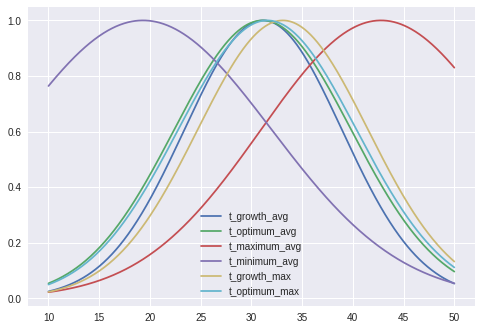

In [0]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

tmp_table = df_bacdive.describe()
x_values = np.linspace(10, 50, 700)
for i in range(1,7):
    tmp = tmp_table.iloc[1:3, [i]]
    plt.plot(x_values, gaussian(x_values, tmp.loc["mean"][0], tmp.loc["std"][0]),label=tmp.columns[0])
plt.legend()
plt.show()

### Save BacDive Extended Table

In [0]:
df_bacdive.to_csv(data_folder_location+"bac_dive_ext.csv")

## Merge and Save Datasets

### Remove too long and too short sequences

In [0]:
df_ncbi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8435335 entries, 0 to 8435334
Data columns (total 4 columns):
refseq_id      object
protein_seq    object
ncbi_tax_id    int64
bacdive_id     int64
dtypes: int64(2), object(2)
memory usage: 257.4+ MB


In [0]:
df_ncbi = df_ncbi[(df_ncbi["protein_seq"].apply(lambda x: len(x)) <= 650) & (df_ncbi["protein_seq"].apply(lambda x: len(x)) >= 50)]

In [0]:
df_ncbi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7708771 entries, 0 to 8435334
Data columns (total 4 columns):
refseq_id      object
protein_seq    object
ncbi_tax_id    int64
bacdive_id     int64
dtypes: int64(2), object(2)
memory usage: 294.1+ MB


In [0]:
gc.collect() #returns number of unreachable objects

9128

### Merge data and save dataframe seperately 

In [0]:
df_ncbi.head()

,refseq_id,protein_seq,ncbi_tax_id,bacdive_id
0,WP_099347303.1,MLSGVLLAFWPSAAHAQAISLDLGQKAGPGTTGRLVQLSALITVIS...,435,1
1,WP_077813381.1,MTVGQRSSFKRNNALLVFLSLASVALLGGVLLAVWPSAAHAQAISL...,435,1
2,WP_035346663.1,MLSGLLLAFWPSAAHAQAISLDLGQKAGPGTTGRLVQLSALITVIS...,435,1
3,WP_018308330.1,MIGVHRRSLTRSNTLLAFLSLAGVALLSGLLLAFWPSAAHAQAISL...,435,1
5,WP_099347454.1,MKKIALSLMLAAGLATAPTFAHAASAHVAWEKYKAGRSLKHLSADG...,435,1


In [0]:
df_ncbi_ext = df_ncbi.join(df_bacdive.set_index('bacdive_id'), on='bacdive_id')

In [0]:
df_ncbi_ext.head()

,refseq_id,protein_seq,ncbi_tax_id,bacdive_id,ncbi_tax_ids,t_conditions,t_growth,t_optimum,t_maximum,t_minimum,t_growth_avg,t_optimum_avg,t_maximum_avg,t_minimum_avg,t_growth_max,t_optimum_max
0,WP_099347303.1,MLSGVLLAFWPSAAHAQAISLDLGQKAGPGTTGRLVQLSALITVIS...,435,1,[435],mesophilic,[[26.0]],None,None,None,26.0,NaN,NaN,NaN,26.0,NaN
1,WP_077813381.1,MTVGQRSSFKRNNALLVFLSLASVALLGGVLLAVWPSAAHAQAISL...,435,1,[435],mesophilic,[[26.0]],None,None,None,26.0,NaN,NaN,NaN,26.0,NaN
2,WP_035346663.1,MLSGLLLAFWPSAAHAQAISLDLGQKAGPGTTGRLVQLSALITVIS...,435,1,[435],mesophilic,[[26.0]],None,None,None,26.0,NaN,NaN,NaN,26.0,NaN
3,WP_018308330.1,MIGVHRRSLTRSNTLLAFLSLAGVALLSGLLLAFWPSAAHAQAISL...,435,1,[435],mesophilic,[[26.0]],None,None,None,26.0,NaN,NaN,NaN,26.0,NaN
5,WP_099347454.1,MKKIALSLMLAAGLATAPTFAHAASAHVAWEKYKAGRSLKHLSADG...,435,1,[435],mesophilic,[[26.0]],None,None,None,26.0,NaN,NaN,NaN,26.0,NaN


In [0]:
del df_bacdive
del df_ncbi

In [0]:
gc.collect()

99

In [0]:
df_ncbi_ext.drop(columns=["protein_seq"]).to_csv(data_folder_location+"bac_dive_ext_properties.csv")

In [0]:
gc.collect()

0

In [0]:
df_sequences = df_ncbi_ext[["protein_seq"]]

In [0]:
df_sequences.to_csv(data_folder_location+"bac_dive_ext_sequences_raw.csv")

In [0]:
del df_ncbi_ext

In [0]:
gc.collect()

17

### Transform sequences into arrays and save

In [0]:
IUPAC_Extended_Dic_Transf = {"A":1,"C":2,"D":3,"E":4,"F":5,"G":6,"H":7,"I":8,"K":9,"L":10,"M":11,"N":12,"P":13,"Q":14,"R":15,"S":16,"T":17,"V":18,"W":19,"Y":20,"B":21,"X":21,"Z":21,"J":21,"U":21,"O":21}

In [0]:
def seq_transf_pad(seq, target_len):
    return np.pad(np.array(list(map(lambda x: IUPAC_Extended_Dic_Transf[x], seq)),dtype="int8"),(0, target_len - len(seq)), 'constant')

In [0]:
#only mesophilic xor thermophilic
def get_X_padded_tranf(df_u,seq_len=650):
    df_u = df_u[["protein_seq"]]
    X_all = np.zeros((len(df_u),seq_len),dtype="int8")

    for i in range(len(df_u)):
        if i%100000==0:
            print("Currently at ",i)
            gc.collect()
        X_all[i] = seq_transf_pad(df_u.iloc[i]["protein_seq"],seq_len)

    return X_all

In [0]:
X = get_X_padded_tranf(df_sequences,seq_len=650)

```
Currently at  0
Currently at  100000
Currently at  200000
Currently at  300000
Currently at  400000
Currently at  500000
Currently at  600000
Currently at  700000
Currently at  800000
Currently at  900000
Currently at  1000000
Currently at  1100000
Currently at  1200000
Currently at  1300000
Currently at  1400000
Currently at  1500000
Currently at  1600000
Currently at  1700000
Currently at  1800000
Currently at  1900000
Currently at  2000000
Currently at  2100000
Currently at  2200000
Currently at  2300000
Currently at  2400000
Currently at  2500000
Currently at  2600000
Currently at  2700000
Currently at  2800000
Currently at  2900000
Currently at  3000000
Currently at  3100000
Currently at  3200000
Currently at  3300000
Currently at  3400000
Currently at  3500000
Currently at  3600000
Currently at  3700000
Currently at  3800000
Currently at  3900000
Currently at  4000000
Currently at  4100000
Currently at  4200000
Currently at  4300000
Currently at  4400000
Currently at  4500000
Currently at  4600000
Currently at  4700000
Currently at  4800000
Currently at  4900000
Currently at  5000000
Currently at  5100000
Currently at  5200000
Currently at  5300000
Currently at  5400000
Currently at  5500000
Currently at  5600000
Currently at  5700000
Currently at  5800000
Currently at  5900000
Currently at  6000000
Currently at  6100000
Currently at  6200000
Currently at  6300000
Currently at  6400000
Currently at  6500000
Currently at  6600000
Currently at  6700000
Currently at  6800000
Currently at  6900000
Currently at  7000000
Currently at  7100000
Currently at  7200000
Currently at  7300000
Currently at  7400000
Currently at  7500000
Currently at  7600000
Currently at  7700000

```



In [0]:
del df_sequences

In [0]:
gc.collect()

36

In [0]:
np.save(data_folder_location + "X.npy", X)

## Validate tranformations and saved data //everything checked out

In [0]:
#df_ncbi_ext.head() as it was created

,refseq_id,protein_seq,ncbi_tax_id,bacdive_id,ncbi_tax_ids,t_conditions,t_growth,t_optimum,t_maximum,t_minimum,t_growth_avg,t_optimum_avg,t_maximum_avg,t_minimum_avg,t_growth_max,t_optimum_max
0,WP_099347303.1,MLSGVLLAFWPSAAHAQAISLDLGQKAGPGTTGRLVQLSALITVIS...,435,1,[435],mesophilic,[[26.0]],None,None,None,26.0,NaN,NaN,NaN,26.0,NaN
1,WP_077813381.1,MTVGQRSSFKRNNALLVFLSLASVALLGGVLLAVWPSAAHAQAISL...,435,1,[435],mesophilic,[[26.0]],None,None,None,26.0,NaN,NaN,NaN,26.0,NaN
2,WP_035346663.1,MLSGLLLAFWPSAAHAQAISLDLGQKAGPGTTGRLVQLSALITVIS...,435,1,[435],mesophilic,[[26.0]],None,None,None,26.0,NaN,NaN,NaN,26.0,NaN
3,WP_018308330.1,MIGVHRRSLTRSNTLLAFLSLAGVALLSGLLLAFWPSAAHAQAISL...,435,1,[435],mesophilic,[[26.0]],None,None,None,26.0,NaN,NaN,NaN,26.0,NaN
5,WP_099347454.1,MKKIALSLMLAAGLATAPTFAHAASAHVAWEKYKAGRSLKHLSADG...,435,1,[435],mesophilic,[[26.0]],None,None,None,26.0,NaN,NaN,NaN,26.0,NaN


In [0]:
X.shape

(7708771, 650)

In [0]:
X[0] #MLSGVLLAFWPSAAHAQAISLDLGQKAGPGTTGRLVQLSALITVIS...

array([11, 10, 16,  6, 18, 10, 10,  1,  5, 19, 13, 16,  1,  1,  7,  1, 14,
        1,  8, 16, 10,  3, 10,  6, 14,  9,  1,  6, 13,  6, 17, 17,  6, 15,
       10, 18, 14, 10, 16,  1, 10,  8, 17, 18,  8, 16, 10,  1, 13, 16, 10,
       10, 18, 11, 18, 17,  1,  5, 17, 15,  8,  8,  8, 18, 10, 16, 10, 10,
       15,  6,  1,  8,  6,  1, 14,  6, 17, 13, 13, 12, 17, 18, 10,  8,  6,
       10,  1, 10,  5, 10, 17,  5,  5, 18, 11, 14, 13, 18,  5,  4, 14, 16,
       19, 12, 12,  6,  8, 16, 13, 10, 18, 12,  6, 17,  8, 16,  4, 11,  3,
        6,  8,  9,  1, 17,  1,  4, 13,  5, 15, 17,  5, 11, 10,  7, 12, 17,
       15, 13, 17,  3, 10,  1, 17,  5, 16,  6, 10,  1,  7, 18,  4, 13, 13,
        9, 17,  1,  1,  3, 17, 13, 19, 15,  8, 10, 11, 13,  1,  5, 11, 18,
        6,  4, 10, 15, 15,  6,  5,  4, 11,  6,  5, 10, 10, 20, 10, 13,  5,
       10, 18,  8,  3, 10, 18, 18, 16, 17, 18, 10, 11, 16, 10,  6, 11, 11,
       11, 10, 13, 13, 17, 17,  8, 16, 10, 13,  5,  9, 10,  8,  5,  5, 18,
       11, 18,  3,  6, 19

In [0]:
X[3] #MIGVHRRSLTRSNTLLAFLSLAGVALLSGLLLAFWPSAAHAQAISL...

array([11,  8,  6, 18,  7, 15, 15, 16, 10, 17, 15, 16, 12, 17, 10, 10,  1,
        5, 10, 16, 10,  1,  6, 18,  1, 10, 10, 16,  6, 10, 10, 10,  1,  5,
       19, 13, 16,  1,  1,  7,  1, 14,  1,  8, 16, 10,  3, 10,  6, 14,  9,
        1,  6, 13,  6, 17, 17,  6, 15, 10, 18, 14, 10, 16,  1, 10,  8, 17,
       18,  8, 16, 10,  1, 13, 16, 10, 10, 18, 11, 18, 17,  1,  5, 17, 15,
        8,  8,  8, 18, 10, 16, 10, 10, 15,  6,  1,  8,  6,  1, 14,  6, 17,
       13, 13, 12, 17, 18, 10,  8,  6, 10,  1, 10,  5, 10, 17,  5,  5, 18,
       11, 14, 13, 18,  5,  4, 14, 16, 19, 12,  3,  6,  8, 16, 13, 10, 18,
       12,  6, 17,  8, 16,  4, 11,  3,  6,  8,  9,  1, 17,  1,  4, 13,  5,
       15, 17,  5, 11, 10,  7, 12, 17, 15, 16, 17,  3, 10,  1, 17,  5, 16,
        6, 10,  1,  7, 18,  4, 13, 13,  9, 17,  1,  1,  3, 17, 13, 19, 15,
        8, 10, 11, 13,  1,  5, 11, 18,  6,  4, 10, 15, 15,  6,  5,  4, 11,
        6,  5, 10, 10, 20, 10, 13,  5, 10, 18,  8,  3, 10, 18, 18, 16, 17,
       18, 10, 11, 16, 10

In [0]:
properties = pd.read_csv(data_folder_location+"bac_dive_ext_properties.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
properties.iloc[0]

Unnamed: 0                    0
refseq_id        WP_099347303.1
ncbi_tax_id                 435
bacdive_id                    1
ncbi_tax_ids              [435]
t_conditions         mesophilic
t_growth               [[26.0]]
t_optimum                   NaN
t_maximum                   NaN
t_minimum                   NaN
t_growth_avg                 26
t_optimum_avg               NaN
t_maximum_avg               NaN
t_minimum_avg               NaN
t_growth_max                 26
t_optimum_max               NaN
Name: 0, dtype: object

In [0]:
properties.iloc[3]

Unnamed: 0                    3
refseq_id        WP_018308330.1
ncbi_tax_id                 435
bacdive_id                    1
ncbi_tax_ids              [435]
t_conditions         mesophilic
t_growth               [[26.0]]
t_optimum                   NaN
t_maximum                   NaN
t_minimum                   NaN
t_growth_avg                 26
t_optimum_avg               NaN
t_maximum_avg               NaN
t_minimum_avg               NaN
t_growth_max                 26
t_optimum_max               NaN
Name: 3, dtype: object

In [0]:
#just check how many with 21 (numer of sequences with non canonical sequences)
np.array(list(map(lambda x: (21 in x), X))).sum()

7400

In [0]:
#save labels as np arrays additionally
np.save(data_folder_location + "y_growth_avg.npy", properties["t_growth_avg"].values)
np.save(data_folder_location + "y_growth_max.npy", properties["t_growth_max"].values)